## House Price Prediction Assignment

### Problem Statement:

A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. 

We are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.


### Business Goals:

The company wants to know:
1. Which variables are significant in predicting the price of a house, and
2. How well those variables describe the price of a house.

Also, determine the optimal value of lambda for ridge and lasso regression.


### Steps:

#### 1. Data Sourcing

    1. Checking the encoding of the file
    2. Loading the data		

#### 2. Data Exploring & Cleaning

    A. Null Values Analysis
        1. Identify and drop columns with 100% missing data
        2. Identify and drop columns with more than 80% missing data
        3. Identify and drop columns having single unique values as they will not any value to the analysis
        4. Identify and drop unnecessary columns (like text based, Applicant Loan Behaviour)

    B. Datatype Check 

    C. Datatype Conversion
        1. Converting int to object
    
    D. Drop Records
        1. Drop Duplicates
    
    E. Impute Null Values
    
    F. Populating the categorical columns with correct mapping
    
    G. Outliers handling
    
    G. Derived Metrics
    
#### 3. Data Visualisation
#### 4. Data Preparation
#### 5. Splitting and Scaling the data
#### 6. Model Building & Evaluation
#### 7. Regualisation using Ridge and Lasso
#### 8. Making Predictions Using the Final Model on the test data
######################################################################

In [1]:
# Importing all required packages
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import cufflinks as cf
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
from pandas.api.types import is_object_dtype,is_string_dtype, is_numeric_dtype
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

%matplotlib inline
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE,RFECV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import tree

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 10000)
py.offline.init_notebook_mode(connected=True) # plotting in offilne mode 
cf.set_config_file(offline=False, world_readable=True, theme='ggplot')
pd.set_option('display.max_colwidth', 1) # make sure data and columns are displayed correctly withput purge
pd.options.display.float_format = '{:20,.2f}'.format # display float value with correct precision 

In [2]:
# Generic Functions

# Method to get Meta-Data about any dataframe passed 
def getMetadata(dataframe) :
    metadata_matrix = pd.DataFrame({
                    'Datatype' : dataframe.dtypes, # data types of columns
                    'Total_Element': dataframe.count(), # total elements in columns
                    'Null_Count': dataframe.isnull().sum(), # total null values in columns
                    'Null_Percentage': round(dataframe.isnull().sum()/len(dataframe) * 100,2) ,# percentage of null values
                    'Unique_Value': dataframe.nunique()
                       })
    return metadata_matrix

def getVIF(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

def binary_map(x):
    return x.map({'yes': 1, "no": 0})

def cross_validation(X_train,y_train,lm):
    folds = KFold(n_splits = 2, shuffle = True, random_state = 100)
    hyper_params = [{'n_features_to_select': list(range(len(X_train.columns)))}]
    lm.fit(X_train, y_train)
    rfe = RFE(lm)             
    model_cv = GridSearchCV(estimator = rfe, 
                            param_grid = hyper_params, 
                            scoring= 'r2', 
                            cv = folds, 
                            verbose = 1,
                            return_train_score=True)      

    model_cv.fit(X_train, y_train)                  
    cv_results = pd.DataFrame(model_cv.cv_results_)
    plt.figure(figsize=(16,6))
    plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
    plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
    plt.xlabel('number of features')
    plt.ylabel('r-squared')
    plt.title("Optimal Number of Features")
    plt.legend(['test score', 'train score'], loc='upper left')
    
def plot_bar_chart(plotting_frame,x_column,y_column) :
            
        x_axis_title = x_column.title()
        y_axis_title = y_column.title()
        
        graph_title = "Bar Chart [" + x_axis_title.title() + " Vs " + y_axis_title.title() + "]"
        
        layout = go.Layout(
             title = graph_title,
             yaxis=dict(
                title=y_axis_title
             ),
             xaxis=dict(
                 title=x_axis_title
             )
        )

        data_to_be_plotted = [
            go.Bar(
                x=plotting_frame[x_column], 
                y=plotting_frame[y_column]
            )
        ]


        figure = go.Figure(data=data_to_be_plotted,layout=layout)
        py.offline.iplot(figure)
        
        
def plot_pie_chart(plotting_frame,x_column,y_column) : 
        
        labels = plotting_frame[x_column].tolist()
        values = plotting_frame[y_column].tolist()

        trace = go.Pie(labels=labels, values=values)

        py.offline.iplot([trace])

        
def plot_box_chart(dataframe) :
    data = []
    for index, column_name in enumerate(dataframe) :
        data.append(
        go.Box(
            y=dataframe.iloc[:, index],
            name=column_name
         ))   
        
    layout = go.Layout(
    yaxis=dict(
        title="Frequency",
        zeroline=False
    ),
       boxmode='group'
    )
    
    fig = go.Figure(data=data, layout=layout)    
    py.offline.iplot(fig) 
    
def plot_group_bar_chart(plot,col,hue) : 
    hue_col = pd.Series(data = hue)
    fig, ax = plt.subplots()
    width = len(plot[col].unique()) + 6 + 5*len(hue_col.unique())
    fig.set_size_inches(width , 10)
    ax = sns.countplot(data = loan_plot, x= col, order=plot[col].value_counts().index,hue = hue,palette="Set2") 
    
    for p in ax.patches:
                # Some segment wise value we are getting as Nan as respective value not present to tackle the Nan using temp_height
                temp_height = p.get_height()
                
                if math.isnan(temp_height):
                    temp_height = 0.01
                    
                
                ax.annotate('{:1.1f}%'.format((temp_height*100)/float(len(loan_plot))), (p.get_x()+0.05, temp_height+20)) 
    
    plt.show()

def col_list(df):
    num_list = []
    cat_list = []
    for column in df:
        if is_numeric_dtype(df[column]):
            num_list.append(column)
        elif is_object_dtype(df[column]):
            cat_list.append(column)    
    return cat_list,num_list

def outliers(df,num_list):
    oc = []
    noc=[]
    l=[]
    u=[]
    for c in num_list:
        data=df[c].values
        lower, upper = np.mean(data) - (np.std(data) * 3), np.mean(data) + (np.std(data) * 3)
        outliers=len([x for x in data if x < lower or x > upper])
        non_outliers=len([x for x in data if x >= lower and x <= upper])
        l.append(lower)
        u.append(upper)
        oc.append(outliers)
        noc.append(non_outliers)
    oc_metric = pd.Series(oc, name = 'Outliers')
    noc_metric = pd.Series(noc, name = 'Non-Outliers')
    lower_limit = pd.Series(l, name = 'Lower Limit')
    uper_limit = pd.Series(u, name = 'Upper Limit')    
    outl = pd.DataFrame(num_list,columns = ['Columns'])
    final_metric = pd.concat([outl, oc_metric, noc_metric,lower_limit,uper_limit], axis = 1)
 #   final_metric.set_index("Columns", inplace = True)
    return final_metric    

def assumption_graph(y_train,y_pred_train):
    
    ### Assumption of Error Terms Being Independent
    y_res_train = y_train - y_pred_train
    plt.scatter( y_pred_train , y_res_train)
    plt.axhline(y=0, color='r', linestyle=':')
    plt.xlabel("Predictions")
    plt.ylabel("Residual")
    plt.show()
    
    # Distribution of errors
    p = sns.distplot(y_res_train,kde=True)
    p = plt.title('Normality of error terms/residuals')
    plt.xlabel("Residuals")
    plt.show()
    
    #### Variance
    sns.regplot(x=y_train, y=y_pred_train)
    plt.title('Predicted Points Vs. Actual Points', fontdict={'fontsize': 20})
    plt.xlabel('Actual Points', fontdict={'fontsize': 15})
    plt.ylabel('Predicted Points', fontdict={'fontsize': 15})
    plt.show()
    print("Shape after outlier correction ",price_df.shape ,"rows & columns.")

def prediction_matrix(model,X_train,X_test,y_train,y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    metric = []
    r2_train_lr = r2_score(y_train, y_pred_train)
    rss_train_lr = np.sum(np.square(y_train - y_pred_train))
    mse_train_lr = mean_squared_error(y_train, y_pred_train)
    adjusted_r2_train_lr= (1 - (1-model.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
    
    r2_test_lr = r2_score(y_test, y_pred_test)
    rss_test_lr = np.sum(np.square(y_test - y_pred_test))
    mse_test_lr = mean_squared_error(y_test, y_pred_test)
    adjusted_r2_test_lr= (1 - (1-model.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)) 
    
    
    metric.append(r2_train_lr)
    metric.append(r2_test_lr)
    metric.append(adjusted_r2_train_lr)
    metric.append(adjusted_r2_test_lr)
    metric.append(rss_train_lr)
    metric.append(mse_test_lr)
    metric.append(mse_train_lr**0.5)
    metric.append(mse_test_lr**0.5)

    y_res_train = y_train - y_pred_train
    y_res_test = y_test - y_pred_test
    
    plt.figure(figsize=(20, 12))
    sns.set(font_scale= 1)
    sns.set_style('whitegrid')
    
    plt.subplot(2,3,1)
#    plt.scatter( y_pred_train , y_res_train)
    sns.scatterplot(x=y_pred_test,y=y_res_test,color='Blue')
    plt.axhline(y=0, color='r', linestyle=':')
    plt.xlabel("Train Predictions")
    plt.ylabel("Train Residual")
    
    plt.subplot(2,3,2)
    p = sns.distplot(y_res_train,kde=True,color='Blue')
    p = plt.title('Normality of error terms/residuals on Train Data')
    plt.xlabel("Residuals")
    

    plt.subplot(2,3,3)
    p=sns.regplot(x=y_train, y=y_pred_train,color='Green')
    p=plt.title('Predicted Points Vs. Actual Points on Train Data')
    plt.xlabel('Actual Points')
    plt.ylabel('Predicted Points')

    plt.subplot(2,3,4)
    sns.scatterplot(x=y_pred_test,y=y_res_test,color='Green')
  #  plt.scatter(y_pred_test , y_res_test)
    plt.axhline(y=0, color='r', linestyle=':')
    plt.xlabel("Test Predictions")
    plt.ylabel("Test Residual")

    plt.subplot(2,3,5)
    p = sns.distplot(y_res_test,kde=True,color='Green')
    p = plt.title('Normality of error terms/residuals on Test Data')
    plt.xlabel("Residuals")

    plt.subplot(2,3,6)
    p=sns.regplot(x=y_test, y=y_pred_test,color='Green')
    p=plt.title('Predicted Points Vs. Actual Points on Test Data')
    plt.xlabel('Actual Points')
    plt.ylabel('Predicted Points') 
    
    sns.despine()
    
#    assumption_graph(y_train,y_pred_train)
#    assumption_graph(y_test,y_pred_test)
    return metric

In [3]:
def cleaning(df):

    print("Records before dropping duplicates  : " + str(df.shape[0]))
    df.drop_duplicates(keep=False,inplace=True)
    print("Records after dropping duplicates  : " + str(df.shape[0]))    
    
    print("Null Value Analysis")
    price_metadata = getMetadata(df)
    price_metadata_group = price_metadata.groupby("Null_Percentage").count().reset_index()
    price_metadata_group.sort_values(["Null_Percentage"], axis=0,ascending=False, inplace=True)
    plot_pie_chart(price_metadata_group,"Null_Percentage","Null_Count")

    print('Completely Missing Data')
    completly_missing_data = price_metadata[price_metadata["Null_Percentage"] == 100.0]
    drop_missing_column = completly_missing_data.index.tolist()
    print("Null Columns before deleting  : " + str(df.shape[1]))
    df.drop(drop_missing_column,inplace=True,axis=1)
    print("Null Columns after deleting : " + str(df.shape[1]))
    
    print('80%+ Missing Data')
    missing_data_greater_80 = price_metadata[(price_metadata["Null_Percentage"] > 80.0) & 
                                         (price_metadata["Null_Percentage"] < 100.0)]
    drop_missing_column_80 = missing_data_greater_80.index.tolist()
    #df.drop(drop_missing_column_80, axis =1, inplace=True)
    display(drop_missing_column_80)
    print("Shape after deleting unique value columns ",df.shape ,"rows & columns.")
    
    print('Identify and drop columns having single value as they will not add any value to our analysis')
    unique_value = df.nunique()
    col_with_only_one_value = unique_value[unique_value.values == 1]
    col_to_drop = col_with_only_one_value.index.tolist()
    display(col_to_drop)
    df.drop(col_to_drop, axis =1, inplace=True)
    print("Shape after deleting unique value columns ",df.shape ,"rows & columns.")
    
    print('Datatype Check')
    price_data_type = getMetadata(df)
    display(price_data_type["Datatype"].value_counts())
    
    price_numeric = df.select_dtypes(include=['object'])
    print('Object Records:')
    display(price_numeric.head(5))

    print('Non Object Records:')
    price_object = df.select_dtypes(exclude=['object'])
    display(price_object.head(5))

    print('Columns requiring imputation:')
    impute_columns = getMetadata(df)
    impute_columns = impute_columns[impute_columns["Null_Count"] > 0]
    display(impute_columns.sort_values(by="Null_Count",ascending = False))
    
    return df

def outlier_treatment(df,columns):
    for col in columns:
        lower_limit=(outlier_info[(outlier_info.Columns==col)]["Lower Limit"].values)[0]
        upper_limit=(outlier_info[(outlier_info.Columns==col)]["Upper Limit"].values)[0]
        df[col]=np.where(df[col]>upper_limit,upper_limit,df[col])
        df[col]=np.where(df[col]<lower_limit,lower_limit,df[col])
    display(df[num_list].describe())

    ### Post fixing outliers
    outlier_columns=outlier_info[outlier_info.Outliers>0]["Columns"]
    i=int(len(outlier_columns)/3)
    plt.figure(figsize=(30,30))
    sns.set(font_scale=1.0)
    sns.set_style("whitegrid")
    j=1
    for p,c in enumerate(columns):
        plt.subplot(i,i,j)
        sns.boxplot(y=df[c],orient="h")
        plt.ylabel(c)
        j=j+1
    plt.show()
    print("Shape after outlier correction ",df.shape ,"rows & columns.")
    return df
    
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("object"):
        df[name] = df[name].fillna("None")
    return df

def encode(df,nominal_feature,ordinal_feature):
    numeric_feature=list(df.select_dtypes(exclude=['object']).columns)
    display(len(ordinal_feature),len(nominal_feature),len(numeric_feature))
    num_list=numeric_feature.copy()
    price_ordinal=df[ordinal_feature]
    price_nominal=df[nominal_feature]
    price_numeric=df[num_list]
    #### Label Encoding
    df[ordinal_feature]=df[ordinal_feature].astype('category')
    for catg in ordinal_feature:
        df[catg]=df[catg].cat.codes
    display("Shape after dummy encoding ",df.shape ,"rows & columns.")
    ### One Hot Encoding
    price_dummies = pd.get_dummies(price_nominal, drop_first=True)
    df = df.drop(list(price_nominal.columns), axis=1)
    df = pd.concat([price_dummies,df],axis = 1)
    display(df.head())
    print("Shape after dummy encoding ",df.shape ,"rows & columns.")
    return df

def baseline(X_train,y_train,X_test,y_test,models):
    cross_metric_train = []
    cross_metric_test =[]
    for i,x in enumerate(models):
        score=cross_val_score(x,X_train,y_train,cv=10,scoring='r2')
        score2=cross_val_score(x,X_test,y_test,cv=10,scoring='r2')
        cross_metric_train.append(score.mean())
        cross_metric_test.append(score2.mean())
    y=pd.Series(cross_metric_test,name='Test')
    lr_table = {'Metric': ['LR','Lasso','Ridge'],
            'Train': cross_metric_train
            }
    lr_df=pd.DataFrame(lr_table,columns=["Metric","Train"])
    baseline_metric=pd.concat([lr_df,y],axis=1)
    display(baseline_metric)


def loadData():
    #input_path='../input/house-prices-advanced-regression-techniques/train.csv'
    train='train.csv'
    test='test.csv'
    train_df=pd.read_csv(train, index_col='Id')
    test_df=pd.read_csv(test,index_col='Id')
    display(train_df.shape,test_df.shape)
    df=pd.concat([train_df,test_df],axis=0)
    print('Top Five Records')
    display(df.head())
    print('Shape',df.info())
    price_metadata=getMetadata(df)
    display(price_metadata)   
    cleaning(df)
    
    return df

## 1.a Load Data and Perform Data Cleaning 

In [4]:
price_df=loadData()

(1460, 80)

(1459, 79)

Top Five Records


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00,Gd,TA,PConc,Gd,TA,No,GLQ,706.00,Unf,0.00,150.00,856.00,GasA,Ex,Y,SBrkr,856,854,0,1710,1.00,0.00,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,"2,003.00",RFn,2.00,548.00,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,"208,500.00"
2,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.00,Unf,0.00,284.00,"1,262.00",GasA,Ex,Y,SBrkr,1262,0,0,1262,0.00,1.00,2,0,3,1,TA,6,Typ,1,TA,Attchd,"1,976.00",RFn,2.00,460.00,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,"181,500.00"
3,60,RL,68.00,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.00,Unf,0.00,434.00,920.00,GasA,Ex,Y,SBrkr,920,866,0,1786,1.00,0.00,2,1,3,1,Gd,6,Typ,1,TA,Attchd,"2,001.00",RFn,2.00,608.00,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,"223,500.00"
4,70,RL,60.00,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.00,TA,TA,BrkTil,TA,Gd,No,ALQ,216.00,Unf,0.00,540.00,756.00,GasA,Gd,Y,SBrkr,961,756,0,1717,1.00,0.00,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,"1,998.00",Unf,3.00,642.00,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,"140,000.00"
5,60,RL,84.00,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00,Gd,TA,PConc,Gd,TA,Av,GLQ,655.00,Unf,0.00,490.00,"1,145.00",GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.00,0.00,2,1,4,1,Gd,9,Typ,1,TA,Attchd,"2,000.00",RFn,3.00,836.00,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,"250,000.00"


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

,Datatype,Total_Element,Null_Count,Null_Percentage,Unique_Value
MSSubClass,int64,2919,0,0.00,16
MSZoning,object,2915,4,0.14,5
LotFrontage,float64,2433,486,16.65,128
LotArea,int64,2919,0,0.00,1951
Street,object,2919,0,0.00,2
Alley,object,198,2721,93.22,2
LotShape,object,2919,0,0.00,4
LandContour,object,2919,0,0.00,4
Utilities,object,2917,2,0.07,2
LotConfig,object,2919,0,0.00,5


Records before dropping duplicates  : 2919
Records after dropping duplicates  : 2919
Null Value Analysis


Completely Missing Data
Null Columns before deleting  : 80
Null Columns after deleting : 80
80%+ Missing Data


['Alley', 'PoolQC', 'Fence', 'MiscFeature']

Shape after deleting unique value columns  (2919, 80) rows & columns.
Identify and drop columns having single value as they will not add any value to our analysis


[]

Shape after deleting unique value columns  (2919, 80) rows & columns.
Datatype Check


object     43
int64      25
float64    12
Name: Datatype, dtype: int64

Object Records:


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
4,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
5,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


Non Object Records:


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,65.00,8450,7,5,2003,2003,196.00,706.00,0.00,150.00,856.00,856,854,0,1710,1.00,0.00,2,1,3,1,8,0,"2,003.00",2.00,548.00,0,61,0,0,0,0,0,2,2008,"208,500.00"
2,20,80.00,9600,6,8,1976,1976,0.00,978.00,0.00,284.00,"1,262.00",1262,0,0,1262,0.00,1.00,2,0,3,1,6,1,"1,976.00",2.00,460.00,298,0,0,0,0,0,0,5,2007,"181,500.00"
3,60,68.00,11250,7,5,2001,2002,162.00,486.00,0.00,434.00,920.00,920,866,0,1786,1.00,0.00,2,1,3,1,6,1,"2,001.00",2.00,608.00,0,42,0,0,0,0,0,9,2008,"223,500.00"
4,70,60.00,9550,7,5,1915,1970,0.00,216.00,0.00,540.00,756.00,961,756,0,1717,1.00,0.00,1,0,3,1,7,1,"1,998.00",3.00,642.00,0,35,272,0,0,0,0,2,2006,"140,000.00"
5,60,84.00,14260,8,5,2000,2000,350.00,655.00,0.00,490.00,"1,145.00",1145,1053,0,2198,1.00,0.00,2,1,4,1,9,1,"2,000.00",3.00,836.00,192,84,0,0,0,0,0,12,2008,"250,000.00"


Columns requiring imputation:


,Datatype,Total_Element,Null_Count,Null_Percentage,Unique_Value
PoolQC,object,10,2909,99.66,3
MiscFeature,object,105,2814,96.40,4
Alley,object,198,2721,93.22,2
Fence,object,571,2348,80.44,4
SalePrice,float64,1460,1459,49.98,663
FireplaceQu,object,1499,1420,48.65,5
LotFrontage,float64,2433,486,16.65,128
GarageCond,object,2760,159,5.45,5
GarageYrBlt,float64,2760,159,5.45,103
GarageFinish,object,2760,159,5.45,3


### 1.b Imputation
#### Imputing values

In [5]:
price_df["SalePrice"].isnull().sum()

1459

In [6]:
price_df["MasVnrArea"].fillna((price_df["MasVnrArea"].median()),inplace=True)
price_df["LotFrontage"].fillna((price_df["LotFrontage"].median()),inplace=True)
#price_df["GarageYrBlt"].fillna((price_df["YearBuilt"]),inplace=True)
price_df["PoolQC"].fillna('NA',inplace=True)
price_df["MiscFeature"].fillna('NA',inplace=True)
price_df["Alley"].fillna('NA',inplace=True)
price_df["Fence"].fillna('NA',inplace=True)
price_df["FireplaceQu"].fillna('NA',inplace=True)
price_df["GarageType"].fillna('NA',inplace=True)
price_df["GarageFinish"].fillna('NA',inplace=True)
price_df["GarageQual"].fillna('NA',inplace=True)
price_df["GarageCond"].fillna('NA',inplace=True)
price_df["BsmtExposure"].fillna('NA',inplace=True)
price_df["BsmtFinType2"].fillna('NA',inplace=True)
price_df["BsmtFinType1"].fillna('NA',inplace=True)
price_df["BsmtCond"].fillna('NA',inplace=True)
price_df["BsmtQual"].fillna('NA',inplace=True)
price_df["MasVnrType"].fillna('None',inplace=True)
price_df["Electrical"].fillna((price_df["Electrical"].mode()[0]),inplace=True)
tmp2=price_df[['SalePrice','GarageYrBlt']]

col_to_drop=['SalePrice','GarageYrBlt']
price_df.drop(col_to_drop, axis=1, inplace=True)
tmp1=impute(price_df)
price_df=pd.concat([tmp1,tmp2],axis=1)

impute_columns = getMetadata(price_df)
impute_columns = impute_columns[impute_columns["Null_Count"] > 0]
impute_columns.sort_values(by="Null_Count",ascending = False)

,Datatype,Total_Element,Null_Count,Null_Percentage,Unique_Value
SalePrice,float64,1460,1459,49.98,663
GarageYrBlt,float64,2760,159,5.45,103


#### Populating categorical values

In [7]:
price_df['MSSubClass'].replace({20:"1-STORY 1946 & NEWER",
                               30:"1-STORY 1945 & OLDER",
                               40:"1-STORY W/FINISHED",
                               45:"1-1/2 STORY - UNFINISHED",
                               50:"1-1/2 STORY FINISHED",
                               60:"2-STORY 1946 & NEWER",
                               70:"2-STORY 1945 & OLDER",
                               75:"2-1/2 STORY ALL AGES",
                               80:"SPLIT OR MULTI-LEVEL",
                               85:"SPLIT FOYER",
                               90:"DUPLEX",
                               120:"1-STORY PUD",
                               150:"1-1/2 STORY PUD",
                               160:"2-STORY PUD",
                               180:"PUD - MULTILEVEL",
                               190:"2 FAMILY CONVERSION"                         
                              },inplace=True)
price_df['MoSold'].replace({1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",
                         7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}
                        ,inplace=True)

print("Shape after correcting categorical columns ",price_df.shape ,"rows & columns.")
price_df.head(5)

Shape after correcting categorical columns  (2919, 80) rows & columns.


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,GarageYrBlt
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2-STORY 1946 & NEWER,RL,65.00,8450,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00,Gd,TA,PConc,Gd,TA,No,GLQ,706.00,Unf,0.00,150.00,856.00,GasA,Ex,Y,SBrkr,856,854,0,1710,1.00,0.00,2,1,3,1,Gd,8,Typ,0,NA,Attchd,RFn,2.00,548.00,TA,TA,Y,0,61,0,0,0,0,NA,NA,NA,0,Feb,2008,WD,Normal,"208,500.00","2,003.00"
2,1-STORY 1946 & NEWER,RL,80.00,9600,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.00,Unf,0.00,284.00,"1,262.00",GasA,Ex,Y,SBrkr,1262,0,0,1262,0.00,1.00,2,0,3,1,TA,6,Typ,1,TA,Attchd,RFn,2.00,460.00,TA,TA,Y,298,0,0,0,0,0,NA,NA,NA,0,May,2007,WD,Normal,"181,500.00","1,976.00"
3,2-STORY 1946 & NEWER,RL,68.00,11250,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.00,Unf,0.00,434.00,920.00,GasA,Ex,Y,SBrkr,920,866,0,1786,1.00,0.00,2,1,3,1,Gd,6,Typ,1,TA,Attchd,RFn,2.00,608.00,TA,TA,Y,0,42,0,0,0,0,NA,NA,NA,0,Sep,2008,WD,Normal,"223,500.00","2,001.00"
4,2-STORY 1945 & OLDER,RL,60.00,9550,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.00,TA,TA,BrkTil,TA,Gd,No,ALQ,216.00,Unf,0.00,540.00,756.00,GasA,Gd,Y,SBrkr,961,756,0,1717,1.00,0.00,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,Unf,3.00,642.00,TA,TA,Y,0,35,272,0,0,0,NA,NA,NA,0,Feb,2006,WD,Abnorml,"140,000.00","1,998.00"
5,2-STORY 1946 & NEWER,RL,84.00,14260,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00,Gd,TA,PConc,Gd,TA,Av,GLQ,655.00,Unf,0.00,490.00,"1,145.00",GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.00,0.00,2,1,4,1,Gd,9,Typ,1,TA,Attchd,RFn,3.00,836.00,TA,TA,Y,192,84,0,0,0,0,NA,NA,NA,0,Dec,2008,WD,Normal,"250,000.00","2,000.00"


### 1.c Outlier Treatment

Category Columns: ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'SaleType', 'SaleCondition']
Continous Columns: ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'Woo

,Columns,Outliers,Non-Outliers,Lower Limit,Upper Limit
0,LotFrontage,29,2890,5.15,133.03
1,LotArea,29,2890,"-13,488.82","33,825.05"
2,OverallQual,4,2915,1.86,10.32
3,OverallCond,58,2861,2.23,8.90
4,YearBuilt,8,2911,"1,880.45","2,062.17"
5,YearRemodAdd,0,2919,"1,921.59","2,046.94"
6,MasVnrArea,63,2856,-435.08,637.87
7,BsmtFinSF1,17,2902,-925.31,"1,807.86"
8,BsmtFinSF2,92,2827,-457.89,557.02
9,BsmtUnfSF,16,2903,-757.97,"1,879.13"


['LotFrontage',
 'LotArea',
 'YearBuilt',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal']

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,SalePrice,GarageYrBlt
count,"2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","1,460.00","2,760.00"
mean,68.78,"9,880.61",6.09,5.56,"1,971.32","1,984.26",96.81,437.99,41.13,559.78,"1,047.35","1,155.36",335.82,1.82,"1,495.47",0.43,0.06,1.57,0.38,2.86,1.04,6.45,0.60,1.77,471.93,92.00,46.04,21.33,0.97,13.82,0.49,28.90,"2,007.79","180,921.20","1,978.11"
std,19.63,"4,645.27",1.41,1.11,30.27,20.89,158.46,437.57,128.48,436.98,418.87,371.29,426.50,15.70,482.60,0.52,0.25,0.55,0.50,0.82,0.21,1.57,0.65,0.76,212.77,118.82,60.73,55.03,8.64,45.63,7.27,180.45,1.31,"79,442.50",25.57
min,21.00,"1,300.00",1.00,1.00,"1,880.45","1,950.00",0.00,0.00,0.00,0.00,0.00,334.00,0.00,0.00,334.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"2,006.00","34,900.00","1,895.00"
25%,60.00,"7,478.00",5.00,5.00,"1,953.50","1,965.00",0.00,0.00,0.00,220.00,793.00,876.00,0.00,0.00,"1,126.00",0.00,0.00,1.00,0.00,2.00,1.00,5.00,0.00,1.00,320.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"2,007.00","129,975.00","1,960.00"
50%,68.00,"9,453.00",6.00,5.00,"1,973.00","1,993.00",0.00,368.00,0.00,467.00,989.00,"1,082.00",0.00,0.00,"1,444.00",0.00,0.00,2.00,0.00,3.00,1.00,6.00,1.00,2.00,480.00,0.00,26.00,0.00,0.00,0.00,0.00,0.00,"2,008.00","163,000.00","1,979.00"
75%,78.00,"11,570.00",7.00,6.00,"2,001.00","2,004.00",163.50,733.00,0.00,805.00,"1,302.00","1,387.50",704.00,0.00,"1,743.50",1.00,0.00,2.00,1.00,3.00,1.00,7.00,1.00,2.00,576.00,168.00,70.00,0.00,0.00,0.00,0.00,0.00,"2,009.00","214,000.00","2,002.00"
max,133.03,"33,825.05",10.00,9.00,"2,010.00","2,010.00",637.87,"1,807.86",557.02,"1,879.13","2,374.55","2,336.47","1,622.37",143.86,"3,018.65",3.00,2.00,4.00,2.00,8.00,3.00,15.00,4.00,5.00,"1,119.21",473.22,250.18,215.80,78.15,184.59,109.23,"1,752.74","2,010.00","755,000.00","2,207.00"


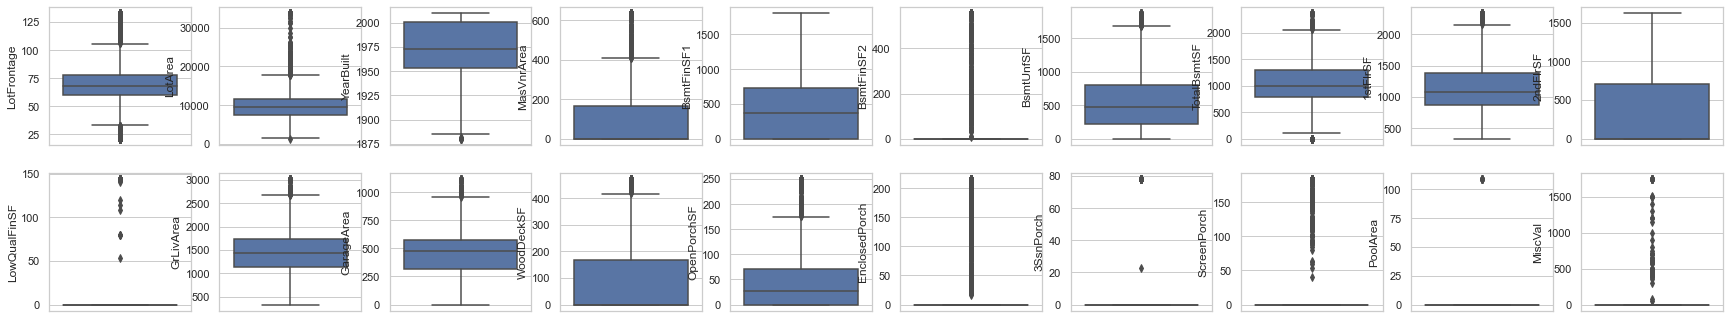

Shape after outlier correction  (2919, 80) rows & columns.


In [8]:
cat_list,num_list=col_list(price_df)
print("Category Columns:",cat_list)
print("Continous Columns:",num_list)
price_df[num_list].describe()
outlier_info=outliers(price_df,num_list)
display(outlier_info)
outlier_columns_fix=outlier_info[(outlier_info["Upper Limit"]>20) & (outlier_info.Outliers>0)]["Columns"]
display(list(outlier_columns_fix))
price_df=outlier_treatment(price_df,list(outlier_columns_fix))

### 1.d Feature Engineering

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,Age,GarageAge,LivLotRatio,Spaciousness,MedNhbdArea
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2-STORY 1946 & NEWER,RL,65.00,"8,450.00",Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2.00,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00,Gd,TA,PConc,Gd,TA,No,GLQ,706.00,Unf,0.00,150.00,856.00,GasA,Ex,Y,SBrkr,856.00,854.00,0.00,"1,710.00",1.00,0.00,2,1,3,1,Gd,8,Typ,0,NA,Attchd,RFn,2.00,548.00,TA,TA,Y,0.00,61.00,0.00,0.00,0.00,0.00,NA,NA,NA,0.00,Feb,WD,Normal,"208,500.00",5.00,5.00,0.20,213.75,"1,504.00"
2,1-STORY 1946 & NEWER,RL,80.00,"9,600.00",Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Others,Feedr,Norm,1Fam,1.00,6,8,Gable,CompShg,MetalSd,MetalSd,None,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.00,Unf,0.00,284.00,"1,262.00",GasA,Ex,Y,SBrkr,"1,262.00",0.00,0.00,"1,262.00",0.00,1.00,2,0,3,1,TA,6,Typ,1,TA,Attchd,RFn,2.00,460.00,TA,TA,Y,298.00,0.00,0.00,0.00,0.00,0.00,NA,NA,NA,0.00,May,WD,Normal,"181,500.00",31.00,31.00,0.13,210.33,"1,706.50"
3,2-STORY 1946 & NEWER,RL,68.00,"11,250.00",Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2.00,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.00,Unf,0.00,434.00,920.00,GasA,Ex,Y,SBrkr,920.00,866.00,0.00,"1,786.00",1.00,0.00,2,1,3,1,Gd,6,Typ,1,TA,Attchd,RFn,2.00,608.00,TA,TA,Y,0.00,42.00,0.00,0.00,0.00,0.00,NA,NA,NA,0.00,Sep,WD,Normal,"223,500.00",7.00,7.00,0.16,297.67,"1,504.00"
4,2-STORY 1945 & OLDER,RL,60.00,"9,550.00",Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2.00,7,5,Gable,CompShg,Wd Sdng,Wd Shng,None,0.00,TA,TA,BrkTil,TA,Gd,No,ALQ,216.00,Unf,0.00,540.00,756.00,GasA,Gd,Y,SBrkr,961.00,756.00,0.00,"1,717.00",1.00,0.00,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,Unf,3.00,642.00,TA,TA,Y,0.00,35.00,215.80,0.00,0.00,0.00,NA,NA,NA,0.00,Feb,WD,Abnorml,"140,000.00",91.00,8.00,0.18,245.29,"1,648.00"
5,2-STORY 1946 & NEWER,RL,84.00,"14,260.00",Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2.00,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00,Gd,TA,PConc,Gd,TA,Av,GLQ,655.00,Unf,0.00,490.00,"1,145.00",GasA,Ex,Y,SBrkr,"1,145.00","1,053.00",0.00,"2,198.00",1.00,0.00,2,1,4,1,Gd,9,Typ,1,TA,Attchd,RFn,3.00,836.00,TA,TA,Y,192.00,84.00,0.00,0.00,0.00,0.00,NA,NA,NA,0.00,Dec,WD,Normal,"250,000.00",8.00,8.00,0.15,244.22,"2,418.00"


Shape after dervived columns  (2919, 81) rows & columns.


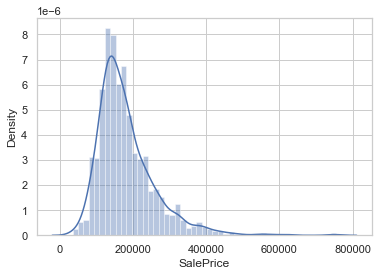

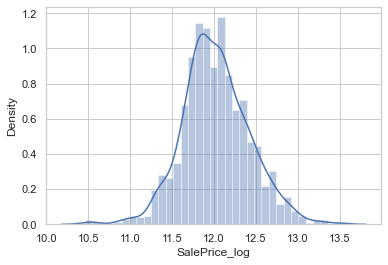

In [9]:
price_df["Age"]=price_df["YrSold"]-price_df["YearBuilt"]
price_df["GarageAge"]=price_df["YrSold"] - price_df["GarageYrBlt"]
price_df["GarageAge"].fillna(99,inplace=True)
price_df["LivLotRatio"] = price_df.GrLivArea / price_df.LotArea
price_df["Spaciousness"] = (price_df["1stFlrSF"] + price_df["2ndFlrSF"]) / price_df.TotRmsAbvGrd
price_df["MedNhbdArea"] = price_df.groupby("Neighborhood")["GrLivArea"].transform("median")
price_df["HouseStyle"]=price_df["HouseStyle"].apply(lambda x: x.replace('Story',''))
price_df["HouseStyle"]=price_df["HouseStyle"].apply(lambda x: x.replace('Fin',''))
price_df["HouseStyle"]=price_df["HouseStyle"].apply(lambda x: x.replace('Unf',''))
price_df["HouseStyle"]=price_df["HouseStyle"].apply(lambda x: x.replace('Lvl',''))
price_df["HouseStyle"]=price_df["HouseStyle"].apply(lambda x: x.replace('Foyer',''))
price_df["HouseStyle"]=price_df["HouseStyle"].apply(lambda x: x.replace('S','1'))
price_df["HouseStyle"]=price_df["HouseStyle"].astype('float64')
MSClass=[k for k,v in zip(list((price_df["MSSubClass"].value_counts()).index),
                          list((price_df["MSSubClass"].value_counts()).values)) if v<70]
Neig=[k for k,v in zip(list((price_df["Neighborhood"].value_counts()).index),
                       list((price_df["Neighborhood"].value_counts()).values)) if v<50]
price_df["MSSubClass"]=price_df["MSSubClass"].apply(lambda x: "Others" if x in MSClass else x)
price_df["Neighborhood"]=price_df["Neighborhood"].apply(lambda x: "Others" if x in Neig else x)
col_to_drop=["YrSold","YearBuilt","GarageYrBlt","YearRemodAdd"]
price_df.drop(col_to_drop,inplace=True,axis=1)
display(price_df.head())
print("Shape after dervived columns ",price_df.shape ,"rows & columns.")
x = price_df["SalePrice"]
sns.set_style("whitegrid")
sns.distplot(x)
plt.show()
price_df["SalePrice_log"] = np.log(price_df.SalePrice)
x = price_df.SalePrice_log
sns.distplot(x)
plt.show()

## 2. Data Visualisation:

In [10]:
impute_columns = getMetadata(price_df)
impute_columns = impute_columns[impute_columns["Null_Count"] > 0]
impute_columns.sort_values(by="Null_Count",ascending = False)

,Datatype,Total_Element,Null_Count,Null_Percentage,Unique_Value
SalePrice,float64,1460,1459,49.98,663
SalePrice_log,float64,1460,1459,49.98,663


Category Columns: ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'SaleType', 'SaleCondition']
Continous Columns: ['LotFrontage', 'LotArea', 'HouseStyle', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'Enc

44

38

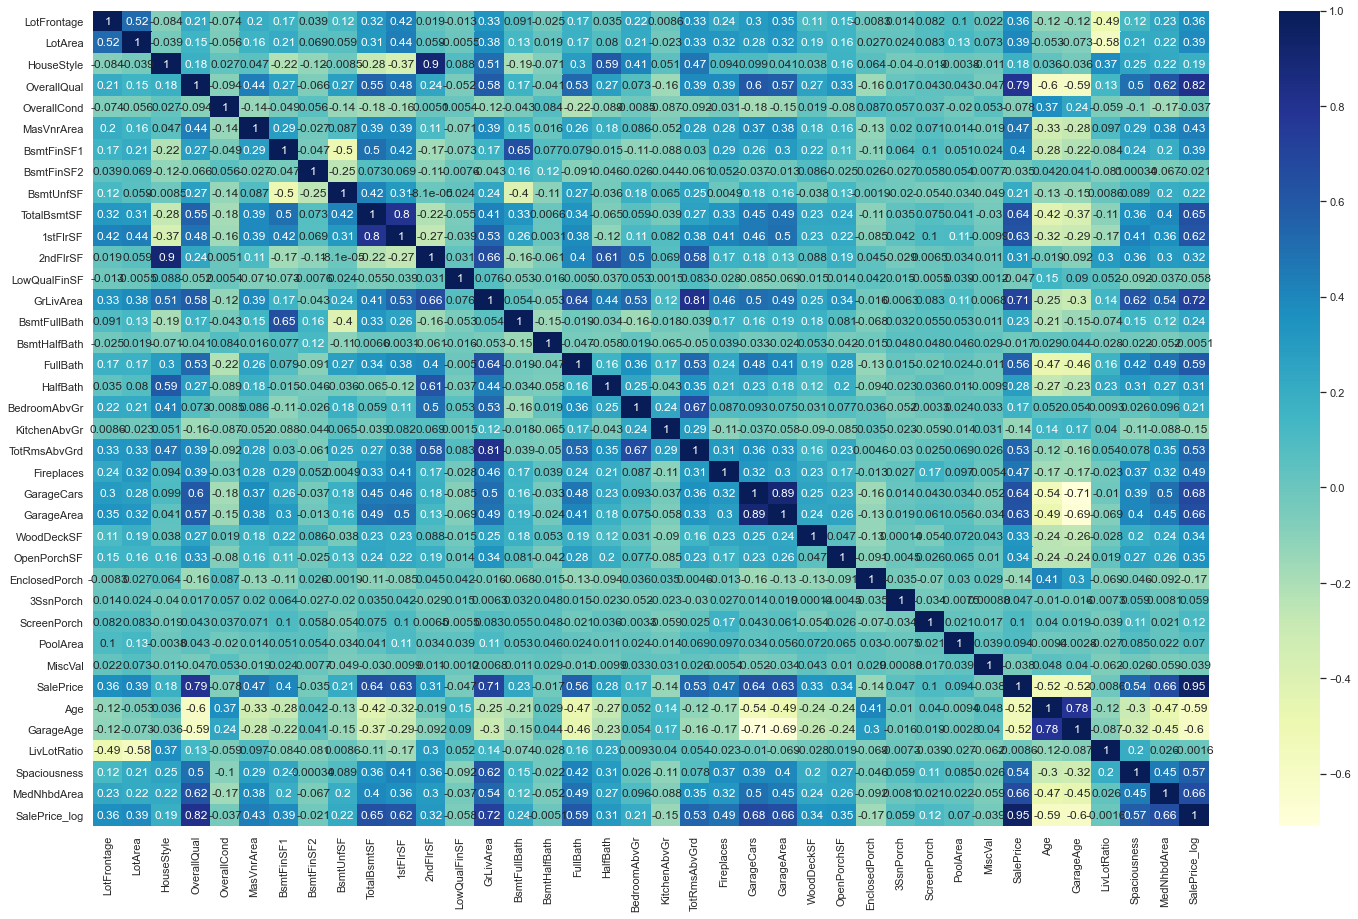

In [11]:
cat_list,num_list=col_list(price_df)
print("Category Columns:",cat_list)
print("Continous Columns:",num_list)
display(len(cat_list),len(num_list))
plt.figure(figsize = (25, 15))
sns.heatmap(price_df[num_list].corr(), annot = True, cmap="YlGnBu")
plt.show()

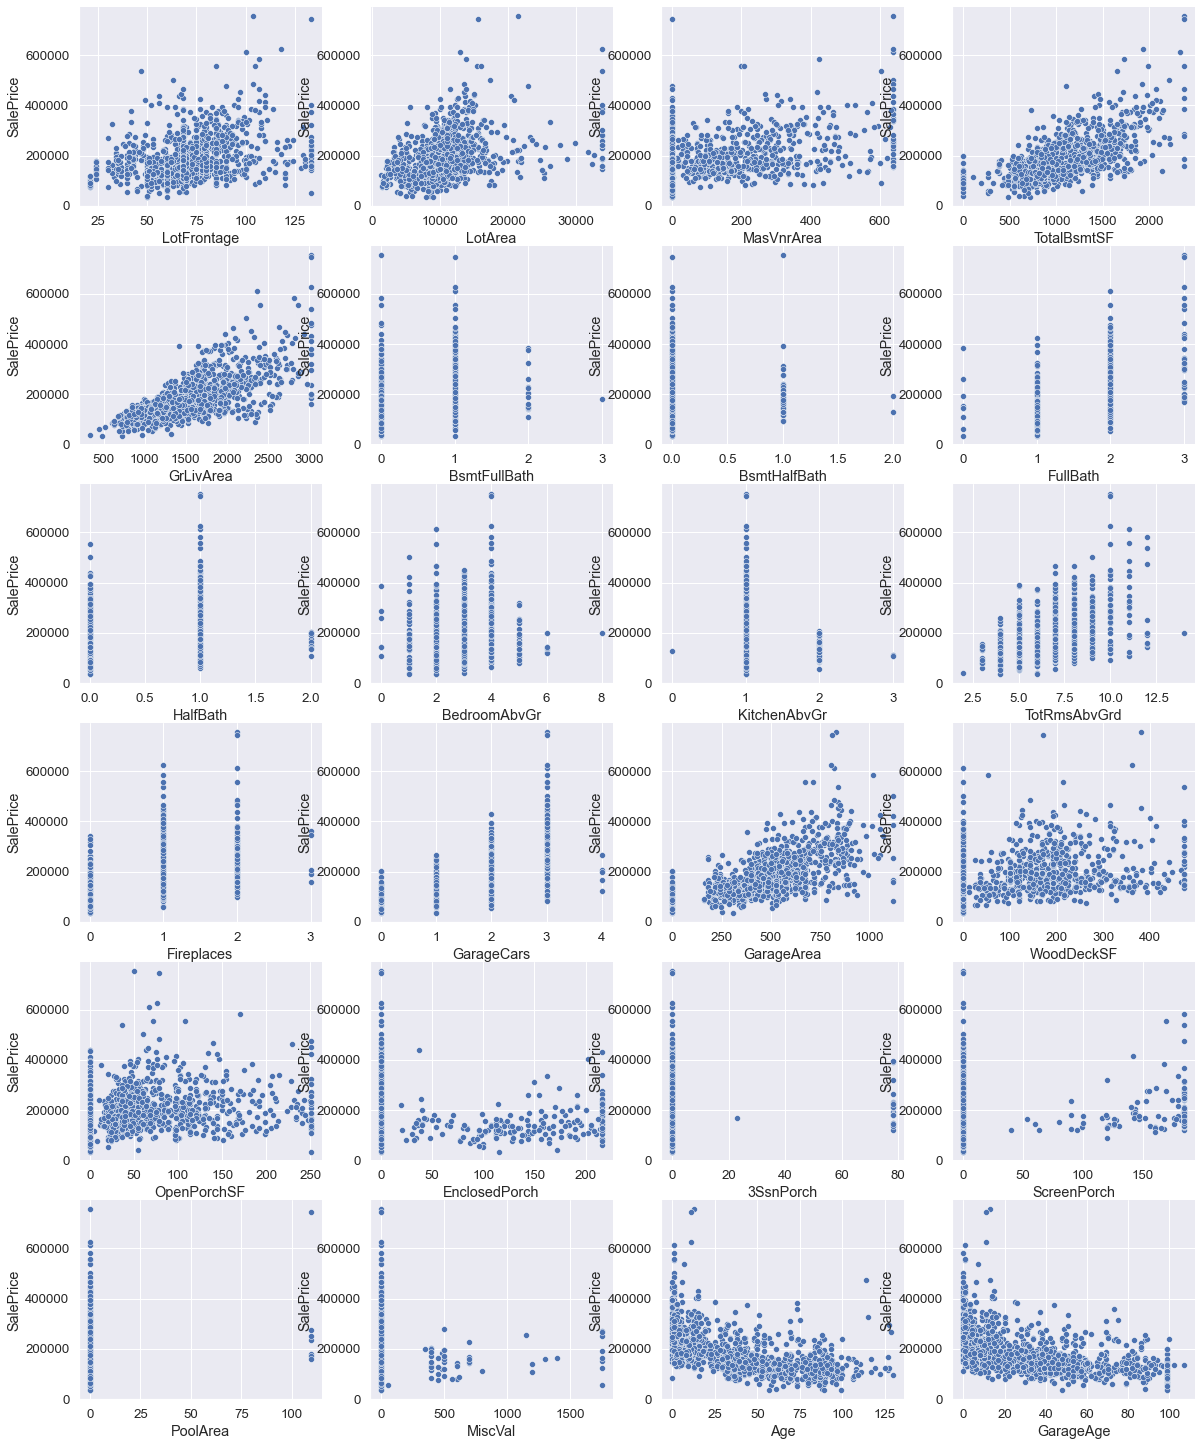

In [12]:
#### Visualising the continous columns columns
Quality_features = ['LotFrontage', 'LotArea', 'MasVnrArea', 'TotalBsmtSF', 'GrLivArea',
                    'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 
                    'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
                    'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal','Age','GarageAge']
plt.figure(figsize=(20, 30))
sns.set(font_scale= 1.2)
sns.set_style('darkgrid')

for i, feature in enumerate(Quality_features):
    plt.subplot(7, 4, i+1)
    sns.scatterplot(data=price_df, x=feature, y='SalePrice', palette="ch:.10")         
sns.despine()

<Figure size 720x720 with 0 Axes>

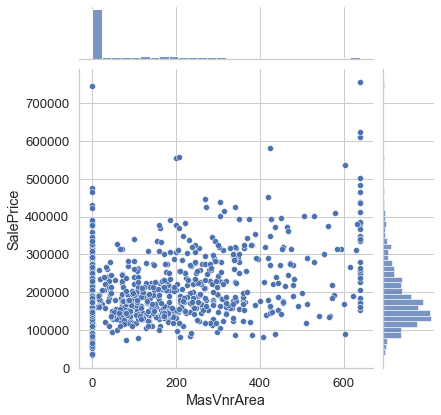

<Figure size 720x720 with 0 Axes>

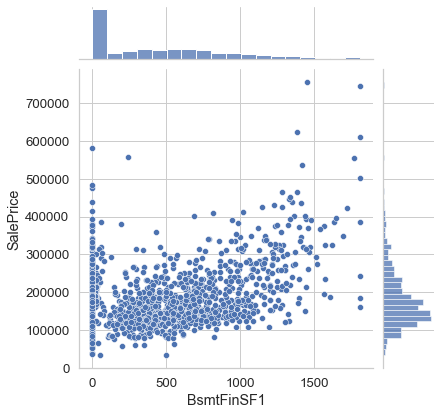

<Figure size 720x720 with 0 Axes>

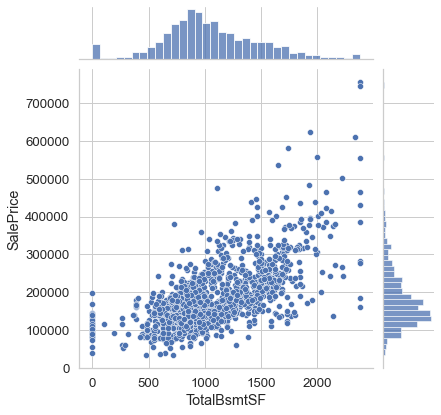

<Figure size 720x720 with 0 Axes>

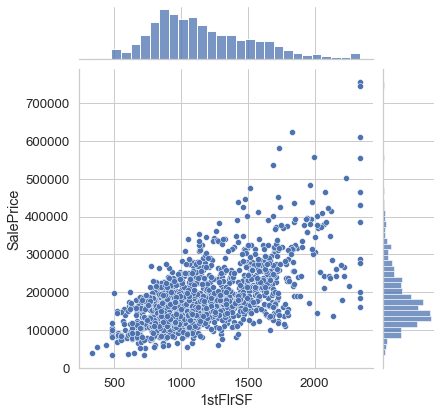

<Figure size 720x720 with 0 Axes>

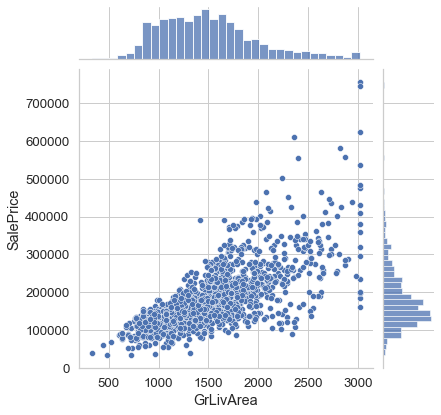

<Figure size 720x720 with 0 Axes>

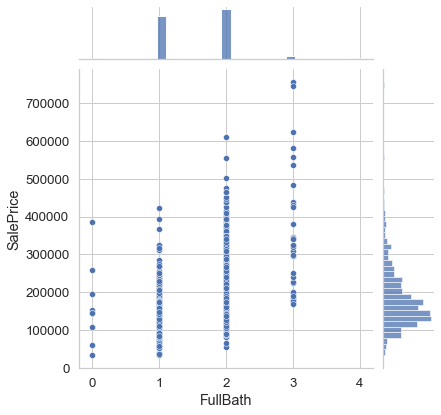

<Figure size 720x720 with 0 Axes>

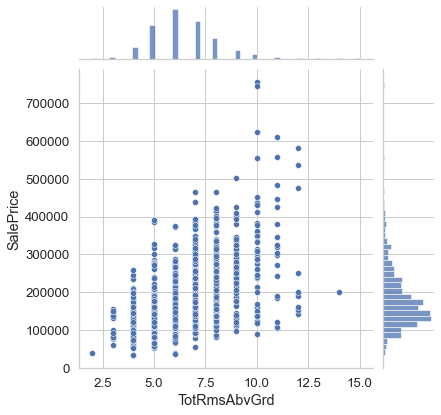

<Figure size 720x720 with 0 Axes>

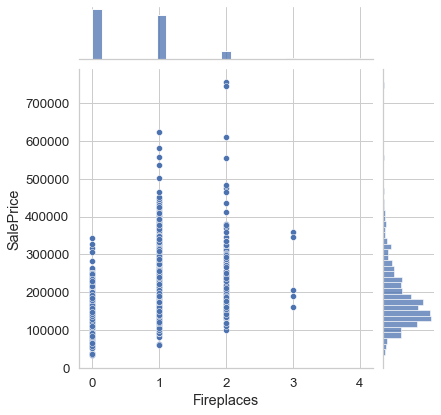

<Figure size 720x720 with 0 Axes>

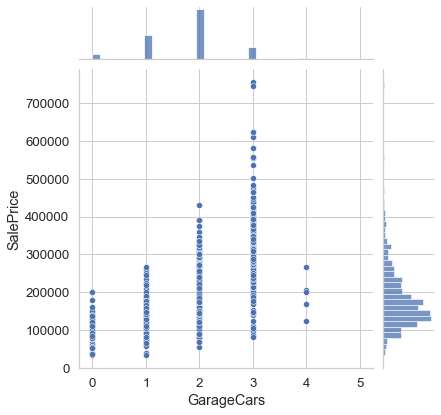

<Figure size 720x720 with 0 Axes>

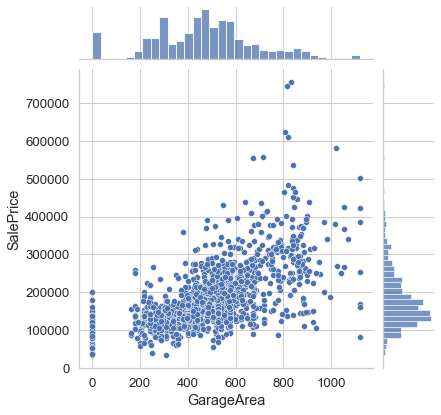

<Figure size 720x720 with 0 Axes>

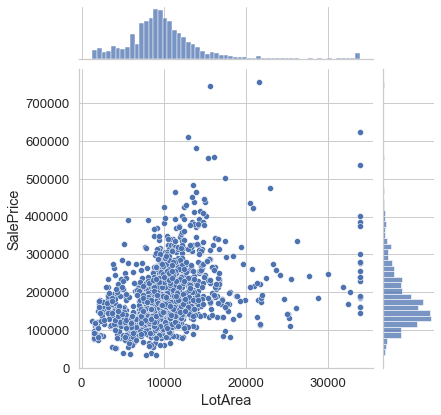

<Figure size 720x720 with 0 Axes>

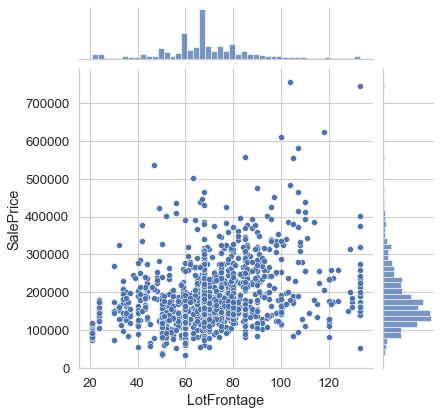

In [13]:
# We will plot some joint histogram and scatter grphs to look at correlated features in more detail
y = price_df["SalePrice"]
features = [
    "MasVnrArea",
    "BsmtFinSF1",
    "TotalBsmtSF",
    "1stFlrSF",
    "GrLivArea",
    "FullBath",
    "TotRmsAbvGrd",
    "Fireplaces",
    "GarageCars",
    "GarageArea",
    "LotArea",
    "LotFrontage",
]

for features in features:
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 10))
    x = price_df[features]
    sns.jointplot(x=x, y=y, data=price_df)

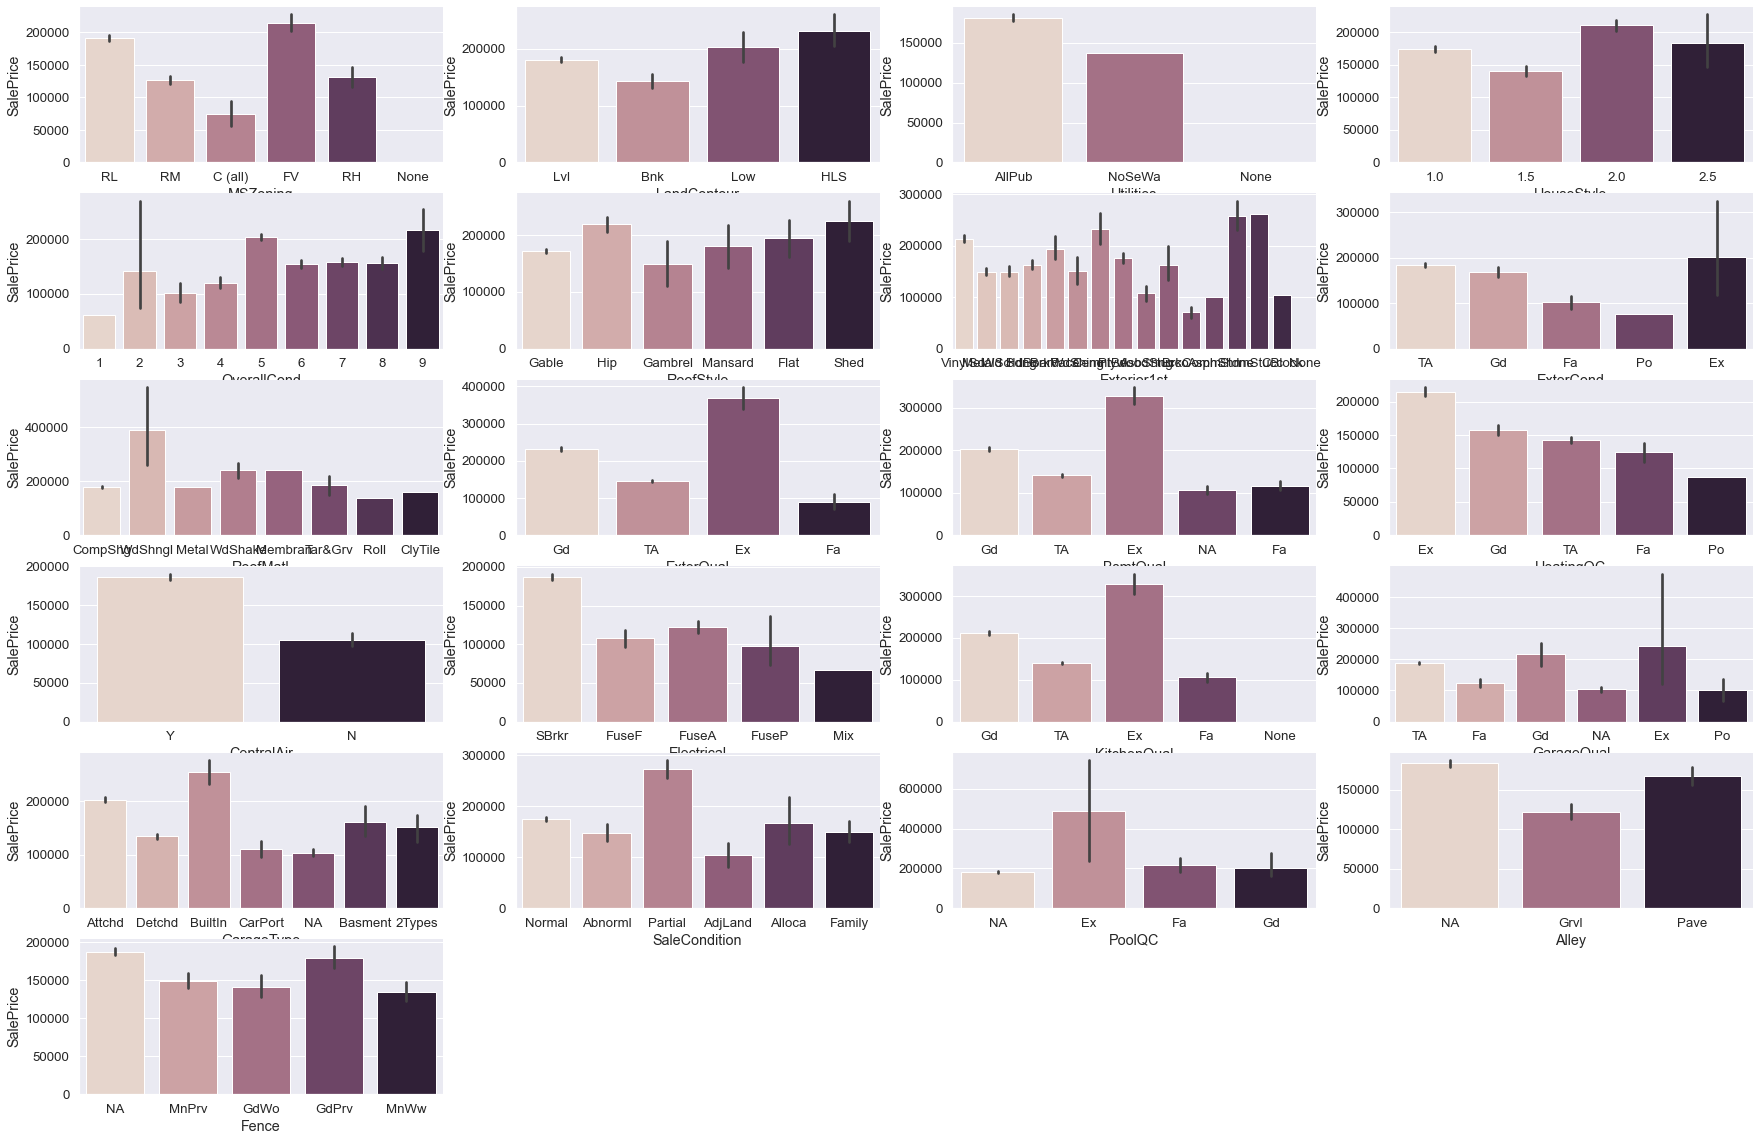

In [14]:
#### Visualising the categorical columns
Quality_features = ['MSZoning','LandContour','Utilities','HouseStyle','OverallCond','RoofStyle','Exterior1st','ExterCond',
                    'RoofMatl', 'ExterQual', 'BsmtQual', 'HeatingQC', 'CentralAir', 
                    'Electrical', 'KitchenQual', 'GarageQual','GarageType','SaleCondition','PoolQC','Alley','Fence']

plt.figure(figsize=(30, 20))
sns.set(font_scale= 1.2)
sns.set_style('darkgrid')

for i, feature in enumerate(Quality_features):
    plt.subplot(6, 4, i+1)
    sns.barplot(data=price_df, x=feature, y='SalePrice', palette="ch:.10")         
sns.despine()

In [15]:
'''
features = price_df.select_dtypes(include=['object']).columns
plt.figure(figsize=(30, 20))
sns.set_style('darkgrid')

for feature in features:
    g = sns.FacetGrid(price_df[~price_df.SalePrice.isnull()], col=feature)
    g.map(plt.hist, 'SalePrice');
    sns.despine()
'''

"\nfeatures = price_df.select_dtypes(include=['object']).columns\nplt.figure(figsize=(30, 20))\nsns.set_style('darkgrid')\n\nfor feature in features:\n    g = sns.FacetGrid(price_df[~price_df.SalePrice.isnull()], col=feature)\n    g.map(plt.hist, 'SalePrice');\n    sns.despine()\n"

**Analysis** - Lots of categorical columns have data skewed to one/two category like:
'MSZoning','Street','Alley','LandContour','Utilities','LandSlope',
'Condition1','Condition2','BldgType','RoofStyle','RoofMatl','ExterCond','BsmtCond',
'BsmtFinType2','Heating','CentralAir','Electrical','Functional',
'GarageQual','GarageCond','PavedDrive','PoolQC','Fence','MiscFeature','SaleType','SaleCondition'
and needs to binned properly

In [16]:
binn_col=['MSZoning','Street','Alley','LandContour',
'Condition1','Condition2','BldgType','RoofStyle','RoofMatl','Heating','CentralAir','Electrical',
'PavedDrive','Fence','MiscFeature','SaleType','SaleCondition']
x=dict()
x["MSZoning"]=300
x["Street"]=10
x["Alley"]=60
x["LandContour"]=70
x["LandSlope"]=70
x["Condition1"]=100
x["Condition2"]=10
x["BldgType"]=120
x["RoofStyle"]=300
x["RoofMatl"]=15
x["Heating"]=20
x['Electrical']=100
x['Functional']=40
x['PavedDrive']=100
x['Fence']=160
x['MiscFeature']=50
x['SaleType']=130
x['SaleCondition']=130
for p,y in x.items():
    val=[k for k,v in zip(list((price_df[p].value_counts()).index),
                       list((price_df[p].value_counts()).values)) if v<y]
    price_df[p]=price_df[p].apply(lambda x: "Others" if x in val else x)
price_df.head()


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,Age,GarageAge,LivLotRatio,Spaciousness,MedNhbdArea,SalePrice_log
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2-STORY 1946 & NEWER,RL,65.00,"8,450.00",Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2.00,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00,Gd,TA,PConc,Gd,TA,No,GLQ,706.00,Unf,0.00,150.00,856.00,GasA,Ex,Y,SBrkr,856.00,854.00,0.00,"1,710.00",1.00,0.00,2,1,3,1,Gd,8,Typ,0,NA,Attchd,RFn,2.00,548.00,TA,TA,Y,0.00,61.00,0.00,0.00,0.00,0.00,NA,NA,NA,0.00,Feb,WD,Normal,"208,500.00",5.00,5.00,0.20,213.75,"1,504.00",12.25
2,1-STORY 1946 & NEWER,RL,80.00,"9,600.00",Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Others,Feedr,Norm,1Fam,1.00,6,8,Gable,CompShg,MetalSd,MetalSd,None,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.00,Unf,0.00,284.00,"1,262.00",GasA,Ex,Y,SBrkr,"1,262.00",0.00,0.00,"1,262.00",0.00,1.00,2,0,3,1,TA,6,Typ,1,TA,Attchd,RFn,2.00,460.00,TA,TA,Y,298.00,0.00,0.00,0.00,0.00,0.00,NA,NA,NA,0.00,May,WD,Normal,"181,500.00",31.00,31.00,0.13,210.33,"1,706.50",12.11
3,2-STORY 1946 & NEWER,RL,68.00,"11,250.00",Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2.00,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.00,Unf,0.00,434.00,920.00,GasA,Ex,Y,SBrkr,920.00,866.00,0.00,"1,786.00",1.00,0.00,2,1,3,1,Gd,6,Typ,1,TA,Attchd,RFn,2.00,608.00,TA,TA,Y,0.00,42.00,0.00,0.00,0.00,0.00,NA,NA,NA,0.00,Sep,WD,Normal,"223,500.00",7.00,7.00,0.16,297.67,"1,504.00",12.32
4,2-STORY 1945 & OLDER,RL,60.00,"9,550.00",Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2.00,7,5,Gable,CompShg,Wd Sdng,Wd Shng,None,0.00,TA,TA,BrkTil,TA,Gd,No,ALQ,216.00,Unf,0.00,540.00,756.00,GasA,Gd,Y,SBrkr,961.00,756.00,0.00,"1,717.00",1.00,0.00,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,Unf,3.00,642.00,TA,TA,Y,0.00,35.00,215.80,0.00,0.00,0.00,NA,NA,NA,0.00,Feb,WD,Abnorml,"140,000.00",91.00,8.00,0.18,245.29,"1,648.00",11.85
5,2-STORY 1946 & NEWER,RL,84.00,"14,260.00",Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2.00,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00,Gd,TA,PConc,Gd,TA,Av,GLQ,655.00,Unf,0.00,490.00,"1,145.00",GasA,Ex,Y,SBrkr,"1,145.00","1,053.00",0.00,"2,198.00",1.00,0.00,2,1,4,1,Gd,9,Typ,1,TA,Attchd,RFn,3.00,836.00,TA,TA,Y,192.00,84.00,0.00,0.00,0.00,0.00,NA,NA,NA,0.00,Dec,WD,Normal,"250,000.00",8.00,8.00,0.15,244.22,"2,418.00",12.43


## 3. Data Prep

In [17]:
ordinal_feature=['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC',
                 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond','LotShape', 'LandSlope', 'BsmtExposure', 
                 'BsmtFinType1', 'BsmtFinType2', 'Functional','GarageFinish','Utilities','PoolQC'
                 ]
nominal_feature= ["MSSubClass", "MSZoning", "Street", "LandContour", 
                "LotConfig", "Neighborhood", "Condition1", "Condition2", "BldgType", 
                 "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", 
                "MasVnrType", "Foundation", "Heating", "CentralAir", "GarageType", 
                 "SaleType", "SaleCondition","PavedDrive",'Electrical','MoSold','Alley','Fence','MiscFeature']
df=encode(price_df,ordinal_feature,nominal_feature)

26

18

38

'Shape after dummy encoding '

(2919, 82)

'rows & columns.'

,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_NA,BsmtQual_TA,BsmtCond_Gd,BsmtCond_NA,BsmtCond_Po,BsmtCond_TA,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_None,KitchenQual_TA,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NA,FireplaceQu_Po,FireplaceQu_TA,GarageQual_Fa,GarageQual_Gd,GarageQual_NA,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_NA,GarageCond_Po,GarageCond_TA,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandSlope_Mod,LandSlope_Others,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_NA,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NA,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_NA,BsmtFinType2_Rec,BsmtFinType2_Unf,Functional_Min2,Functional_Others,Functional_Typ,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,Utilities_NoSeWa,Utilities_None,PoolQC_Fa,PoolQC_Gd,PoolQC_NA,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,Foundation,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageType,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,Age,GarageAge,LivLotRatio,Spaciousness,MedNhbdArea,SalePrice_log
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,5,1,65.00,"8,450.00",1,1,2,4,1,1,1,0,2.00,7,5,0,0,13,14,1,196.00,2,706.00,0.00,150.00,856.00,0,1,2,856.00,854.00,0.00,"1,710.00",1.00,0.00,2,1,3,1,8,0,1,2.00,548.00,2,0.00,61.00,0.00,0.00,0.00,0.00,1,0,0.00,3,2,1,"208,500.00",5.00,5.00,0.20,213.75,"1,504.00",12.25
2,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,2,1,80.00,"9,600.00",1,1,2,2,12,0,1,0,1.00,6,8,0,0,8,8,2,0.00,1,978.00,0.00,284.00,"1,262.00",0,1,2,"1,262.00",0.00,0.00,"1,262.00",0.00,1.00,2,0,3,1,6,1,1,2.00,460.00,2,298.00,0.00,0.00,0.00,0.00,0.00,1,0,0.00,8,2,1,"181,500.00",31.00,31.00,0.13,210.33,"1,706.50",12.11
3,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,5,1,68.00,"11,250.00",1,1,2,4,1,1,1,0,2.00,7,5,0,0,13,14,1,162.00,2,486.00,0.00,434.00,920.00,0,1,2,920.00,866.00,0.00,"1,786.00",1.00,0.00,2,1,3,1,6,1,1,2.00,608.00,2,0.00,42.00,0.00,0.00,0.00,0.00,1,0,0.00,11,2,1,"223,500.00",7.00,7.00,0.16,297.67,"1,504.00",12.32
4,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,4,1,60.00,"9,550.00",1,1,2,0,2,1,1,0,2.00,7,5,0,0,14,16,2,0.00,0,216.00,0.00,540.00,756.00,0,1,2,961.00,756.00,0.00,"1,717.00",1.00,0.00,1,0,3,1,7,1,5,3.00,642.00,2,0.00,35.00,215.80,0.00,0.00,0.00,1,0,0.00,3,2,0,"140,000.00",91.00,8.00,0.18,245.29,"1,648.00",11.85
5,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,5,1,84.00,"14,260.00",1,1,2,2,9,1,1,0,2.00,8,5,0,0,13,14,1,350.00,2,655.00,0.00,490.00,"1,145.00",0,1,2,"1,145.00","1,053.00",0.00,"2,198.00",1.00,0.00,2,1,4,1,9,1,1,3.00,836.00,2,192.00,84.00,0.00,0.00,0.00,0.00,1,0,0.00,2,2,1,"250,000.00",8.00,8.00,0.15,244.22,"2,418.00",12.43


Shape after dummy encoding  (2919, 134) rows & columns.


## Step 4: Splitting and Scaling the data

In [18]:
train=df[~df.SalePrice.isnull()]
test=df[df.SalePrice.isnull()]
display(train.shape,test.shape)

(1460, 134)

(1459, 134)

In [19]:
np.random.seed(0)
df_train, df_validation = train_test_split(train, train_size = 0.7, test_size = 0.3, random_state = 100)

#### Dividing into X and Y sets for the model building

In [20]:
X_train = df_train.drop(["SalePrice_log","SalePrice"], axis = 1)
y_train = df_train["SalePrice_log"]
X_validation = df_validation.drop(["SalePrice_log","SalePrice"], axis = 1)
y_validation = df_validation["SalePrice_log"]
X_test = test.drop(["SalePrice_log","SalePrice"], axis = 1)

In [21]:
num_list=list(X_train.select_dtypes(exclude=['object']).columns)

In [22]:
num_list.remove('LivLotRatio')

In [23]:
### Scaling
scaler = RobustScaler()
#scaler=StandardScaler()
X_train[num_list] = scaler.fit_transform(X_train[num_list])
X_validation[num_list] = scaler.transform(X_validation[num_list])
X_train.head()

,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_NA,BsmtQual_TA,BsmtCond_Gd,BsmtCond_NA,BsmtCond_Po,BsmtCond_TA,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_None,KitchenQual_TA,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NA,FireplaceQu_Po,FireplaceQu_TA,GarageQual_Fa,GarageQual_Gd,GarageQual_NA,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_NA,GarageCond_Po,GarageCond_TA,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandSlope_Mod,LandSlope_Others,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_NA,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NA,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_NA,BsmtFinType2_Rec,BsmtFinType2_Unf,Functional_Min2,Functional_Others,Functional_Typ,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,Utilities_NoSeWa,Utilities_None,PoolQC_Fa,PoolQC_Gd,PoolQC_NA,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,Foundation,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageType,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,Age,GarageAge,LivLotRatio,Spaciousness,MedNhbdArea
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
211,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,-1.00,0.00,0.00,1.00,0.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.33,0.00,-0.06,-0.96,0.00,0.00,0.00,0.00,-0.50,0.00,0.00,0.00,0.00,-0.50,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.11,0.00,-0.11,-0.25,0.00,-1.00,-2.00,-0.41,0.00,0.00,-0.95,1.00,0.00,-1.00,0.00,-1.00,0.00,-0.50,-1.00,1.25,-2.00,-1.94,0.00,0.00,-0.36,96.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.20,0.00,0.00,1.07,1.60,0.15,-0.92,-0.82
319,0.00,1.00,-1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,-1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,-1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.22,0.10,0.00,0.00,1.00,0.00,0.25,0.00,0.00,0.00,1.00,0.50,0.00,0.00,0.00,-1.20,-1.17,-1.00,1.62,1.00,0.84,0.00,-0.17,0.68,0.00,0.00,0.00,0.52,1.75,0.00,1.86,1.00,0.00,0.00,1.00,1.00,0.00,1.50,0.00,0.00,1.00,0.71,0.00,2.02,0.50,144.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.20,0.00,0.00,-0.39,-0.33,0.27,1.16,2.44
240,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,-1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,-0.67,0.00,-0.89,-0.19,0.00,0.00,0.00,0.00,-0.50,0.00,0.00,0.00,0.50,0.00,-1.00,0.00,0.00,0.20,0.17,0.00,0.00,0.00,-0.42,0.00,0.30,-0.49,0.00,0.00,-2.00,-0.53,0.95,0.00,0.03,0.00,0.00,-1.00,1.00,0.00,0.00,0.50,0.00,1.00,-1.00,-1.05,0.00,0.00,1.64,0.00,0.00,0.00,0.00,-1.00,0.00,0.00,-1.20,0.00,0.00,0.67,0.72,0.17,-0.24,-0.82
987,0.00,0.00,0.00,0.00,1.00,0.00,-1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,-1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,-1.00,0.00,0.00,1.00,0.00,0.00,1

In [24]:
X_test[num_list]=scaler.transform(X_test[num_list])

## Step 5: Model Building & Evaluation

#### i. Baseline Score

In [25]:
models=[LinearRegression(),Lasso(),Ridge()]
baseline(X_train,y_train,X_validation,y_validation,models)

,Metric,Train,Test
0,LR,0.88,0.83
1,Lasso,0.02,-0.02
2,Ridge,0.88,0.84


#### ii. Linear Regression

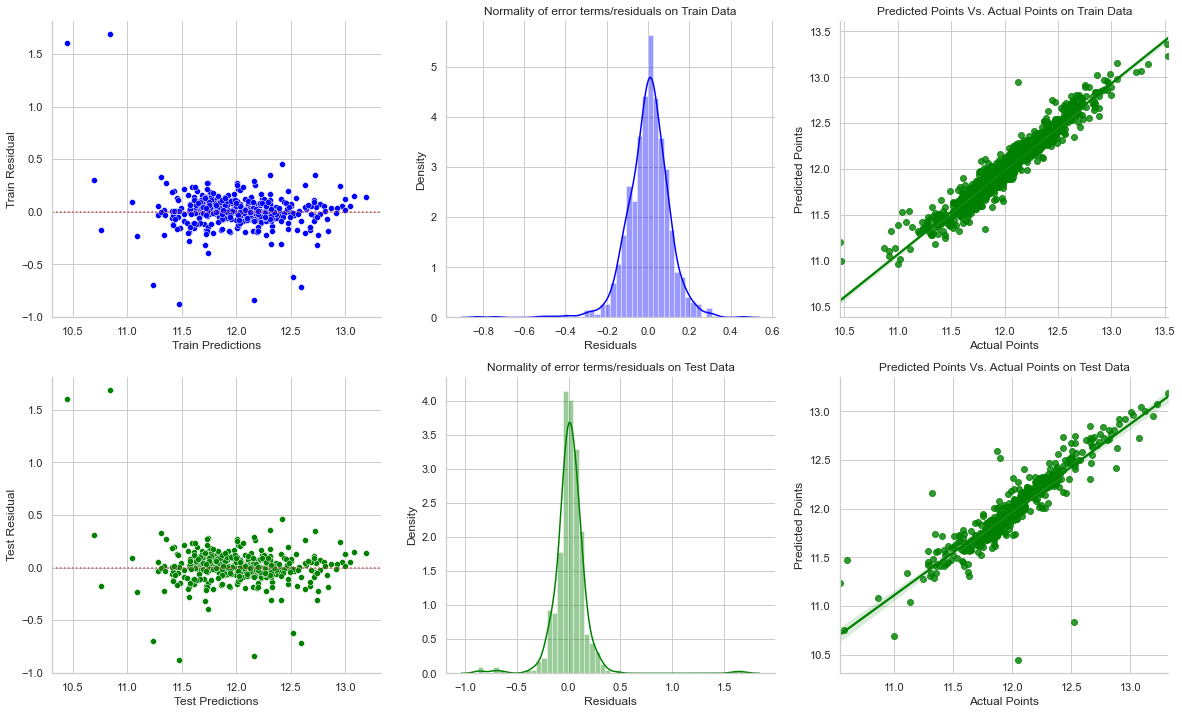

In [26]:
lm = LinearRegression()
lm.fit(X_train, y_train)
lm_metric=prediction_matrix(lm,X_train,X_validation,y_train,y_validation)

#### iii. RFE Implementation for feature selection

Optimal number of features : 65


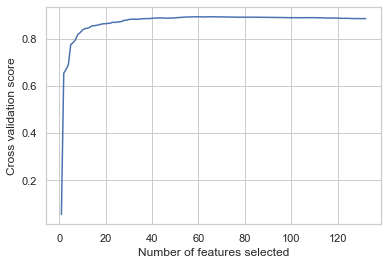

In [27]:
#cross_validation(X_train,y_train,lm)
min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(estimator=Ridge(), step=1, cv=10,
              scoring='r2',
              min_features_to_select=min_features_to_select)
rfecv.fit(X_train, y_train)
print("Optimal number of features : %d" % rfecv.n_features_)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

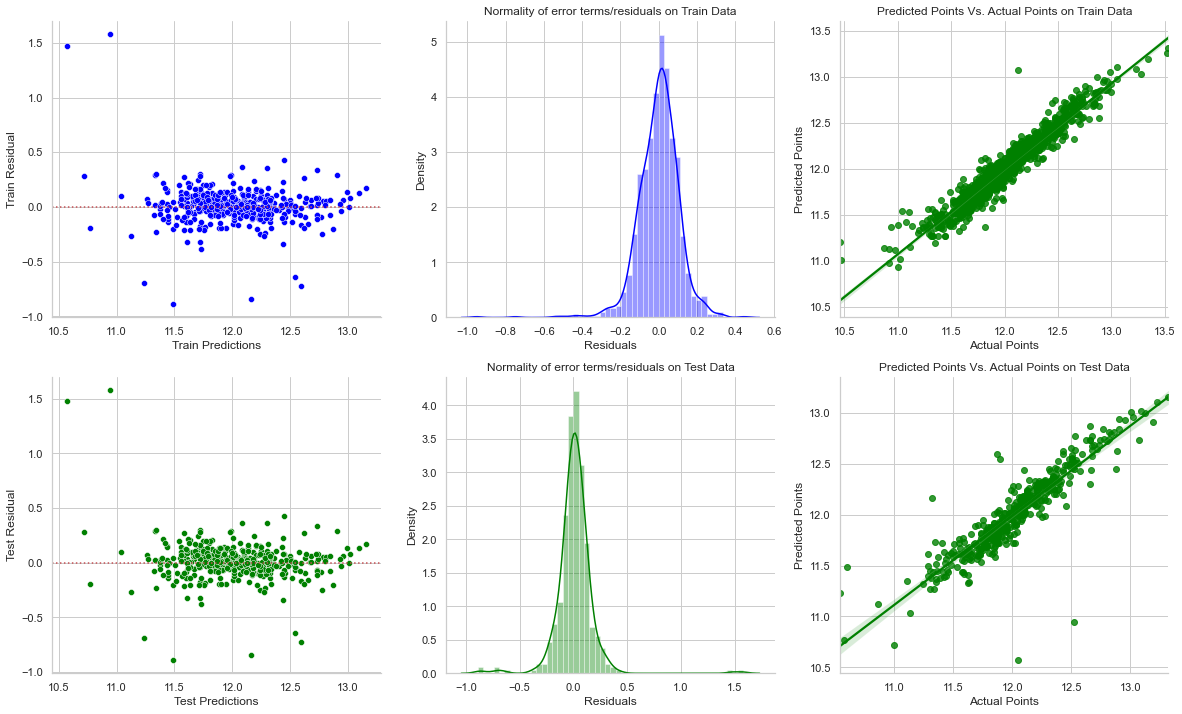

In [28]:
### selecting columns post rfe
col = X_train.columns[rfecv.support_]
len(list(col))
X_train_rfe = X_train[col]
X_validation_rfe  = X_validation[col]
lm_rfe=LinearRegression()
lm_rfe.fit(X_train_rfe,y_train)
lm_rfe_metric=prediction_matrix(lm_rfe,X_train_rfe,X_validation_rfe,y_train,y_validation)

#### iv. Ridge Regression

Fitting 5 folds for each of 11 candidates, totalling 55 fits


{'alpha': 1.0}

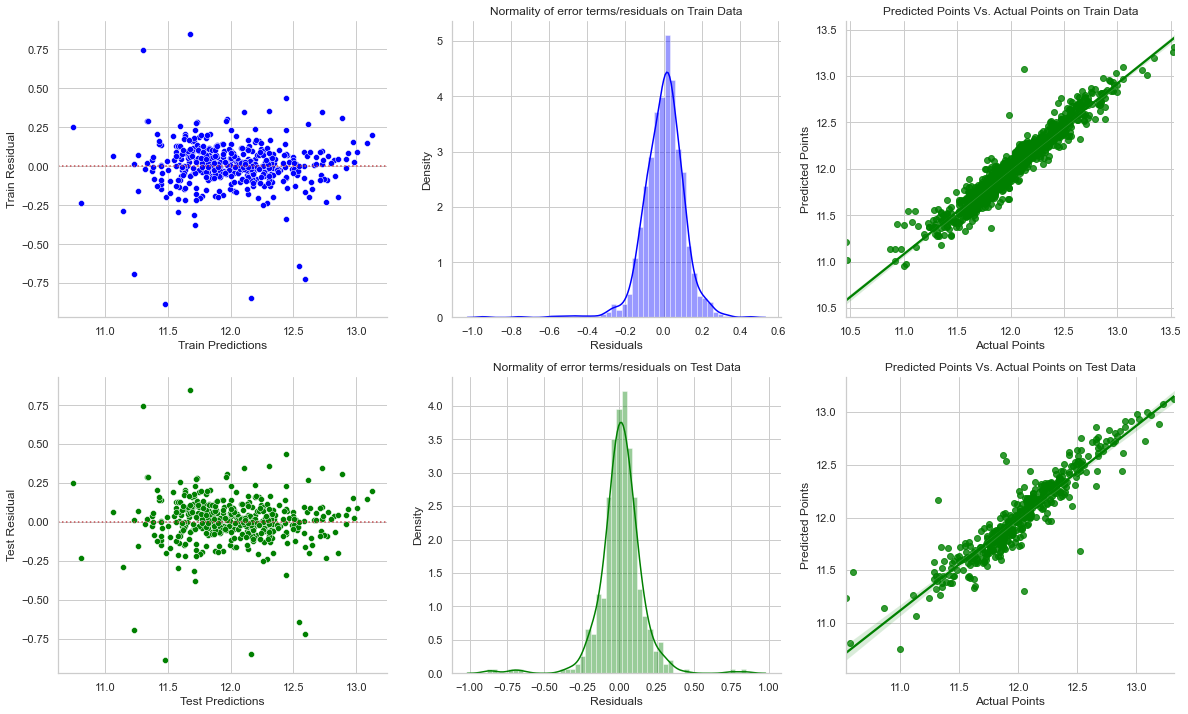

In [29]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.001, 0.01, 0.1, 1.0,10.0,20,50,100,150,200,500]}
estimator = Ridge()
# cross validation
folds = 5
model_cv = GridSearchCV(estimator = estimator, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train_rfe, y_train) 
display(model_cv.best_params_)
alpha = model_cv.best_params_['alpha']
ridge = Ridge(alpha=alpha)
ridge.fit(X_train_rfe, y_train)
lm_ridge_metric=prediction_matrix(ridge,X_train_rfe,X_validation_rfe,y_train,y_validation)

#### v. Lasso Regression

Fitting 5 folds for each of 13 candidates, totalling 65 fits


{'alpha': 0.001}

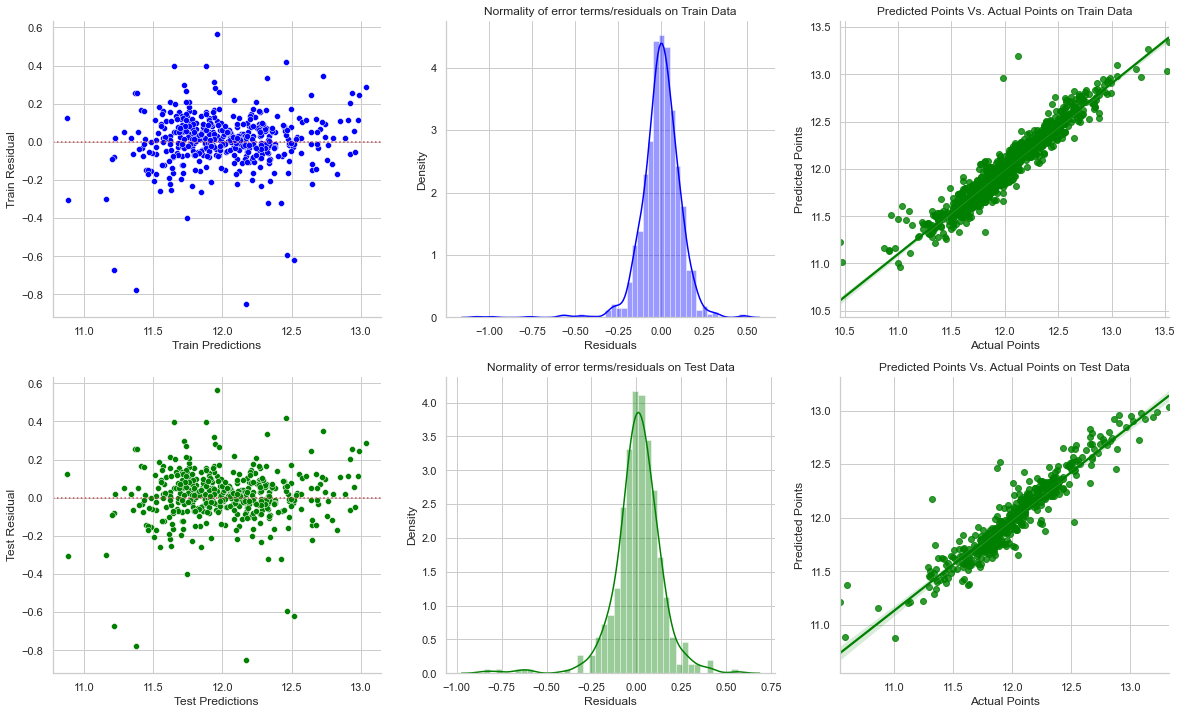

In [49]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.00001,0.0001,0.001, 0.01, 0.1, 1.0,10.0,20,50,100,150,200,500]}
#params = {'alpha': [0.001, 0.0001, 0.0005, 0.005,0.003 ]}
estimator = Lasso()
# cross validation
folds = 5
model_cv = GridSearchCV(estimator = estimator, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 
display(model_cv.best_params_)
alpha = model_cv.best_params_['alpha']
lasso = Lasso(alpha=alpha)
lasso.fit(X_train, y_train) 
lm_lasso_metric=prediction_matrix(lasso,X_train,X_validation,y_train,y_validation)

#### vi. Decision Tree

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


DecisionTreeRegressor(max_depth=10, min_samples_leaf=10, random_state=42)

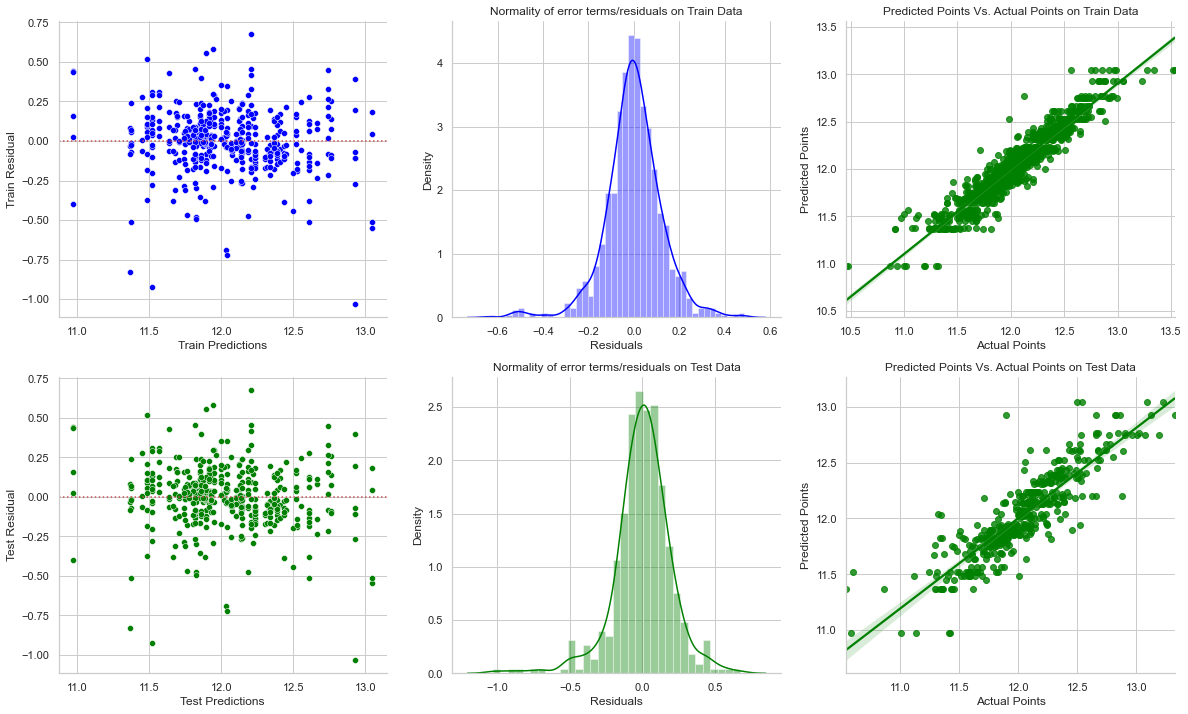

In [42]:
params = {
    'criterion':['mse'],
    'splitter':['best'],
    'max_depth':[5,10,15,20,40,50],
    'min_samples_split':[2,5,10,20,50,100],
    'min_samples_leaf':[1,2,3,5,10,20],
    'random_state':[42,100],
}
estimator = tree.DecisionTreeRegressor()
# cross validation
folds = 5
model_cv = GridSearchCV(estimator = estimator, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)  
%%time
model_cv.fit(X_train, y_train) 
display(model_cv.best_estimator_)
lm_dt=model_cv.best_estimator_
lm_dt.fit(X_train, y_train) 
lm_dt_metric=prediction_matrix(lm_dt,X_train,X_validation,y_train,y_validation)

#### vii. Random Forest

In [ ]:
params = {
    'criterion':['mse'],
    'max_depth':[5,10,15,20,40],
    'min_samples_split':[5,10,20],
    'min_samples_leaf':[3,5,10,20],
    'random_state':[42,100],
    'max_features': [50,75,100,140],
    'n_estimators':[10,30,50,100],
    'n_jobs':[-1],
    'oob_score':[True]
    
}
estimator = RandomForestRegressor()
# cross validation
folds = 3
model_cv = GridSearchCV(estimator = estimator, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)  
model_cv.fit(X_train, y_train) 
display(model_cv.best_estimator_)
lm_rfc=model_cv.best_estimator_
lm_rfc.fit(X_train, y_train) 
lm_rfc_metric=prediction_matrix(lm_rfc,X_train,X_validation,y_train,y_validation)

Fitting 3 folds for each of 1920 candidates, totalling 5760 fits


#### viii. KNN Regression

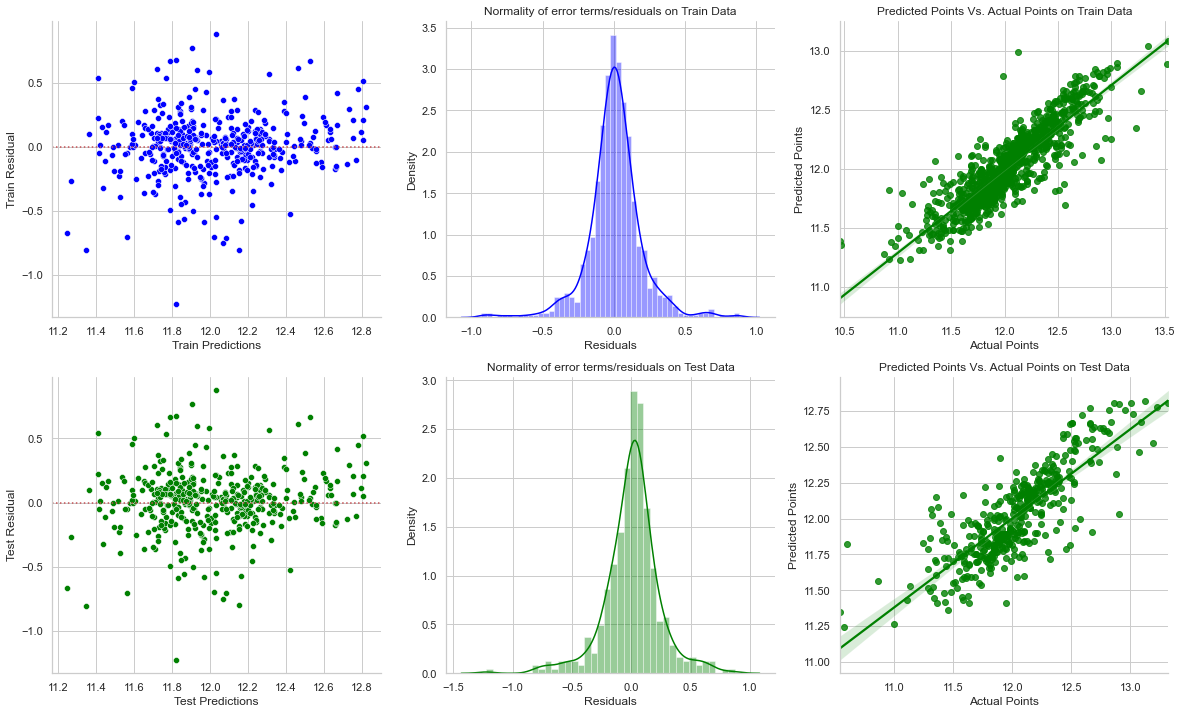

In [33]:
lm_knn=KNeighborsRegressor(n_neighbors=5)
lm_knn.fit(X_train, y_train) 
lm_knn_metric=prediction_matrix(lm_knn,X_train,X_validation,y_train,y_validation)

#### ix. Gradient Boosting

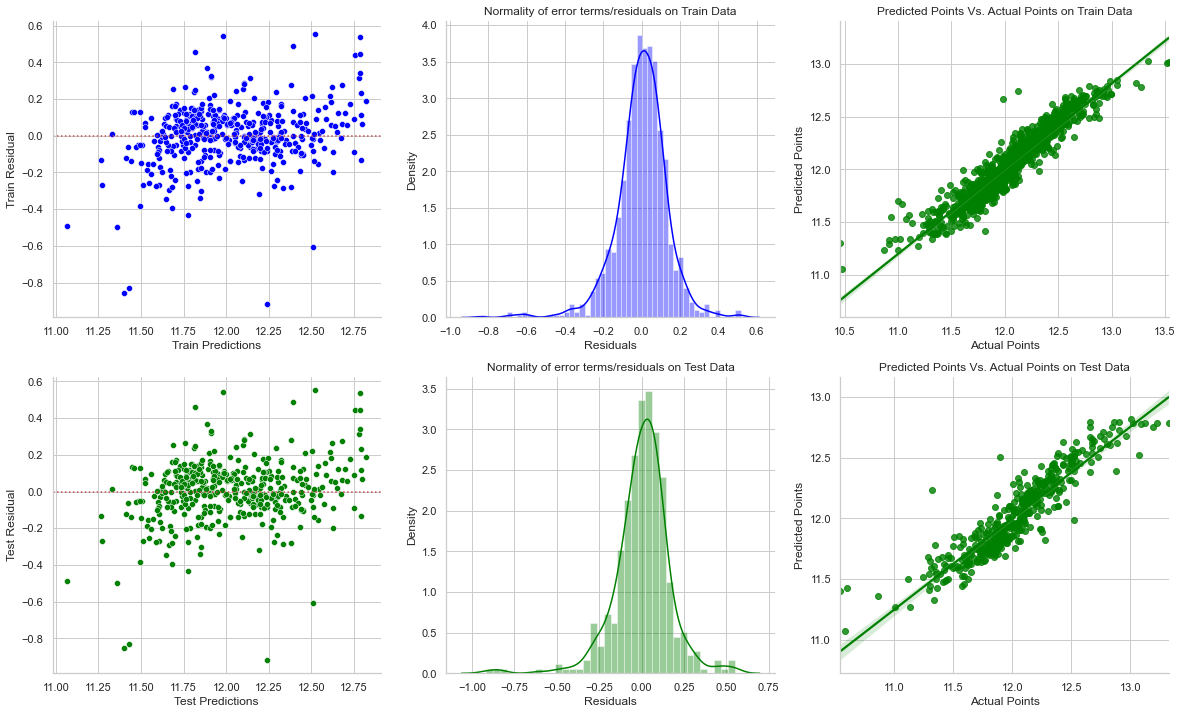

In [34]:
lm_gbr = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01, max_depth=1, random_state=31)
lm_gbr.fit(X_train, y_train) 
lm_gbr_metric=prediction_matrix(lm_gbr,X_train,X_validation,y_train,y_validation)

#### x. XGB Regrssor

In [43]:
# Creating a table which contain all the metrics
lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','Adjusted R2 Score (Train)','Adjusted R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'RMSE (Train)','RMSE (Test)'], 
        'Linear Regression': lm_metric
        }

metric_lm = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )
metric_lm_rfe = pd.Series(lm_rfe_metric,name = 'RFE Linear Regression')
metric_lm_ridge = pd.Series(lm_ridge_metric, name = 'Ridge Regression')
metric_lm_lasso = pd.Series(lm_lasso_metric, name = 'Lasso Regression')
metric_lm_dt = pd.Series(lm_dt_metric,name = 'Decision Tree Regression')
metric_lm_rfc = pd.Series(lm_rfc_metric, name = 'Random Forest Regression')
metric_lm_knn= pd.Series(lm_knn_metric, name = 'KNN Regression')
metric_lm_gbr = pd.Series(lm_gbr_metric, name = 'Gradient Boosting Regression')

final_metric = pd.concat([metric_lm,metric_lm_rfe,metric_lm_ridge,metric_lm_lasso,metric_lm_dt,metric_lm_rfc,metric_lm_knn,metric_lm_gbr], axis = 1)
print("Model Peformance Metric:")
display(final_metric)

Model Peformance Metric:


,Metric,Linear Regression,RFE Linear Regression,Ridge Regression,Lasso Regression,Decision Tree Regression,Random Forest Regression,KNN Regression,Gradient Boosting Regression
0,R2 Score (Train),0.93,0.93,0.92,0.91,0.90,0.98,0.77,0.89
1,R2 Score (Test),0.81,0.82,0.86,0.88,0.76,0.85,0.67,0.83
2,Adjusted R2 Score (Train),0.92,0.92,0.92,0.90,0.89,0.98,0.74,0.87
3,Adjusted R2 Score (Test),0.73,0.78,0.84,0.83,0.66,0.79,0.52,0.76
4,RSS (Train),11.12,11.78,12.27,14.14,15.97,2.89,36.61,18.21
5,RSS (Test),0.03,0.03,0.02,0.02,0.04,0.02,0.06,0.03
6,RMSE (Train),0.10,0.11,0.11,0.12,0.13,0.05,0.19,0.13
7,RMSE (Test),0.18,0.17,0.15,0.14,0.20,0.16,0.23,0.17


## Step 6: Making Predictions Using the Final Model on the test data

In [36]:
X_test.shape

(1459, 132)

In [37]:
temp=X_test
temp=temp.reset_index()
output_df=temp['Id']
models=[lm,lasso,lm_dt,lm_rfc,lm_knn,lm_gbr]
for i,m in enumerate(models):
    filename=str(i)+'_submission_file.csv'
    lm_price=m.predict(X_test)
    mp = pd.Series(lm_price, name = 'SalePrice')
    final_metric = pd.concat([output_df,mp], axis = 1)
    final_metric['SalePrice']=final_metric['SalePrice'].apply(lambda x: np.exp(x))
    final_metric.to_csv(filename,index =False)